In [419]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import hvplot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelling and forecasting
# ==============================================================================
import itertools
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


import warnings
warnings.filterwarnings('ignore')

In [420]:
riceprice=requests.get("https://www.ec.europa.eu/agrifood/api/rice/prices?")
df_riceprice_rawdata=pd.DataFrame(riceprice.json())

df_riceprice=df_riceprice_rawdata.copy()
df_riceprice["price"]=df_riceprice["price"].str.replace("€","") # removing the € character in price column
df_riceprice["price"]=pd.to_numeric(df_riceprice["price"])   # changing price data into numeric data type
display(df_riceprice)
df_riceprice.to_csv('countrydata.csv')

,memberStateCode,memberStateName,beginDate,endDate,weekNumber,price,unit,marketingYear,stage,type,variety
0,EL,Greece,16/01/2006,22/01/2006,21,175.0,Tonne,2005/2006,Paddy,Indica,Average
1,EL,Greece,12/12/2005,18/12/2005,16,170.0,Tonne,2005/2006,Paddy,Indica,Average
2,EL,Greece,05/12/2005,11/12/2005,15,170.0,Tonne,2005/2006,Paddy,Indica,Average
3,EL,Greece,10/10/2005,16/10/2005,7,160.0,Tonne,2005/2006,Paddy,Indica,Average
4,EL,Greece,19/09/2005,25/09/2005,4,165.0,Tonne,2005/2006,Paddy,Indica,Average
...,...,...,...,...,...,...,...,...,...,...,...
19171,IT,Italy,22/08/2016,28/08/2016,52,280.0,Tonne,2015/2016,Paddy,Japonica,Ribe
19172,IT,Italy,17/11/2014,23/11/2014,12,337.0,Tonne,2014/2015,Paddy,Japonica,Ribe
19173,IT,Italy,02/02/2015,08/02/2015,23,380.0,Tonne,2014/2015,Paddy,Japonica,Ribe
19174,IT,Italy,11/05/2015,17/05/2015,37,365.0,Tonne,2014/2015,Paddy,Japonica,Ribe


In [421]:
italyrice_df=df_riceprice.query('memberStateName == "Italy"')
italyrice_df.to_csv('italyricedata.csv')
italyrice_df.drop(columns=['memberStateCode','endDate','weekNumber','marketingYear'],inplace=True)
italyrice_df.dropna()



,memberStateName,beginDate,price,unit,stage,type,variety
91,Italy,11/02/2002,310.00,Tonne,Paddy,Japonica,Ariete
92,Italy,26/02/2001,322.79,Tonne,Paddy,Japonica,Ariete
93,Italy,23/04/2001,333.11,Tonne,Paddy,Japonica,Ariete
94,Italy,22/10/2001,286.63,Tonne,Paddy,Japonica,Ariete
95,Italy,23/10/2000,296.96,Tonne,Paddy,Japonica,Ariete
...,...,...,...,...,...,...,...
19171,Italy,22/08/2016,280.00,Tonne,Paddy,Japonica,Ribe
19172,Italy,17/11/2014,337.00,Tonne,Paddy,Japonica,Ribe
19173,Italy,02/02/2015,380.00,Tonne,Paddy,Japonica,Ribe
19174,Italy,11/05/2015,365.00,Tonne,Paddy,Japonica,Ribe


In [422]:
italyrice_df['beginDate']=pd.to_datetime(italyrice_df['beginDate'],format="%d/%m/%Y")#sets datetime format
italyrice_df.sort_values('beginDate',inplace=True)#sort by date ascending
display(italyrice_df.head(5)) 
meanpriceitalydf=italyrice_df.groupby([pd.Grouper(key='beginDate',freq='W'),'stage'])['price'].mean().reset_index()#variety and type not taken into consideration just stage of production
paddypriceitaly=meanpriceitalydf.query('stage == "Paddy"')#below block is just for paddy stage of rice
paddypriceitaly=paddypriceitaly.set_index('beginDate')
paddypriceitaly=paddypriceitaly.asfreq('1W')
paddypriceitaly=paddypriceitaly.sort_index()
paddypriceitaly.to_csv('priceofpaddyrice.csv')


,memberStateName,beginDate,price,unit,stage,type,variety
5447,Italy,2000-09-25,278.89,Tonne,Paddy,Japonica,Ariete
13969,Italy,2000-09-25,278.89,Tonne,Paddy,Japonica,Lido
10106,Italy,2000-09-25,273.72,Tonne,Paddy,Indica,Thaibonnet
1339,Italy,2000-10-02,278.89,Tonne,Paddy,Japonica,Lido
10108,Italy,2000-10-02,273.72,Tonne,Paddy,Indica,Thaibonnet


In [423]:
(paddypriceitaly.index == pd.date_range(
                    start = paddypriceitaly.index.min(),
                    end   = paddypriceitaly.index.max(),
                    freq  = paddypriceitaly.index.freq)).all()

print(f"Missing values: {paddypriceitaly.isnull().any(axis=1).sum()}")#checking for missing values, of which there are 220 weeks missing
paddypriceitaly.fillna(method='ffill', inplace=True)#ideally we use machine learning to fill in the missing values but for now missing weeks will have previous weeks data
print(f"Missing values: {paddypriceitaly.isnull().any(axis=1).sum()}")#now 0 missing


Missing values: 220
Missing values: 0


In [424]:
# Split data: train-validation-test

end_train = '2018-01-01'
end_validation = '2020-01-01'

data_train = paddypriceitaly.loc[: end_train, :]
data_val   = paddypriceitaly.loc[end_train:end_validation, :]
data_test  = paddypriceitaly.loc[end_validation:, :]

print(f"Training dates   : {data_train.index.min()} --- {data_train.index.max()}")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}")

Training dates   : 2000-10-01 00:00:00 --- 2017-12-31 00:00:00
Validation dates : 2018-01-07 00:00:00 --- 2019-12-29 00:00:00
Test dates       : 2020-01-05 00:00:00 --- 2022-05-01 00:00:00


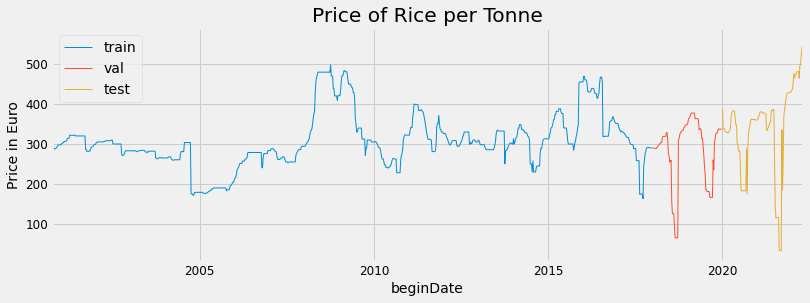

In [425]:
fig, ax = plt.subplots(figsize=(12, 4))
data_train.price.plot(ax=ax, label='train', linewidth=1)
data_val.price.plot(ax=ax, label='val', linewidth=1)
data_test.price.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Price of Rice per Tonne')
ax.set_ylabel('Price in Euro')
ax.legend()


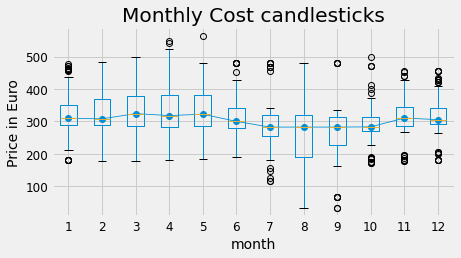

In [426]:
fig, ax = plt.subplots(figsize=(7, 3.5))
paddypriceitaly['month'] = paddypriceitaly.index.month
paddypriceitaly.boxplot(column='price', by='month', ax=ax,)
paddypriceitaly.groupby('month')['price'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Price in Euro')
ax.set_title('Monthly Cost candlesticks')
fig.suptitle('');#variations over 12 month period. The July-October period is promising as it shows a strong seasonal trend of the price being the lowest during that period every year
#this can be seen by the candlesticks all being lower and more compact in that period.

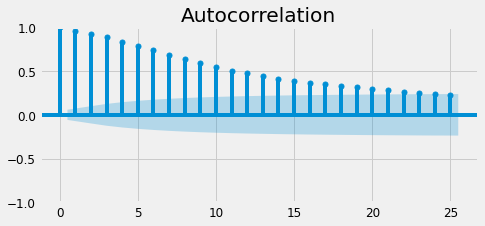

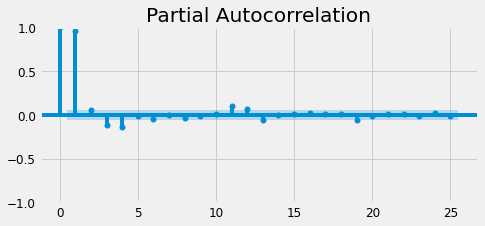

In [427]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(paddypriceitaly.price, ax=ax, lags=25)
plt.show()#the autocorrelation below suggests that current price of rice is based off of previous price if lags 1 or 2 are used
#so a second or third order regressive model is best
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(paddypriceitaly.price, ax=ax, lags=25)
plt.show()

Weekly Data


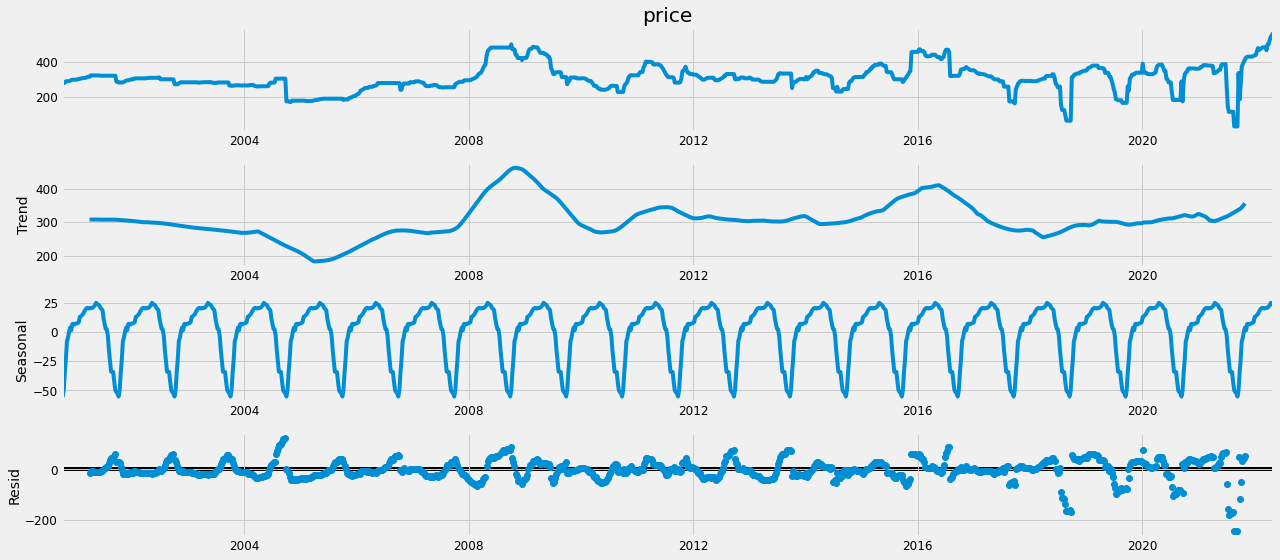

beginDate
2000-10-01    280.995667
2000-11-01    289.861250
2000-12-01    297.220500
2001-01-01    300.838125
2001-02-01    305.840625
                 ...    
2022-01-01    454.438000
2022-02-01    476.818750
2022-03-01    481.511250
2022-04-01    527.922500
2022-05-01    564.000000
Freq: MS, Name: price, Length: 260, dtype: float64
Monthly Data


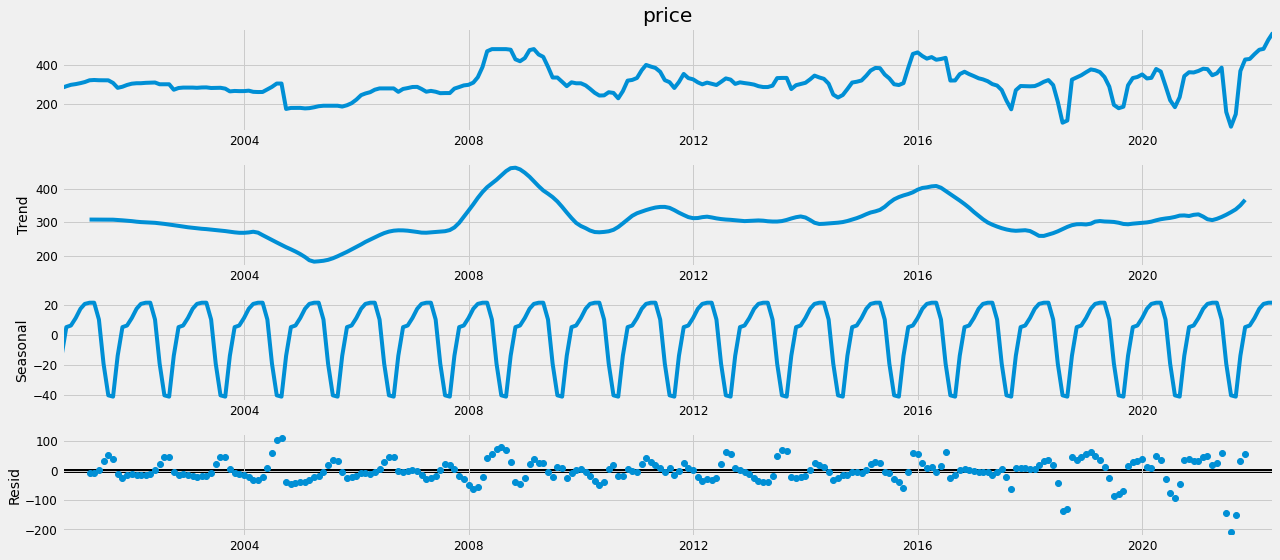

In [428]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(paddypriceitaly.price, model='additive')
fig = decomposition.plot()
print('Weekly Data')
plt.show()#seasonal graph shows a strong seasonality for rice production that most likely correlates to harvest season price being lowest as it is when most paddy rice is available
#The weekly data did not lend itself to machine learning, there was just too much variance and the SARIMAX model for time-series data was not able to forecast future trends so a monthly model was used in the end

monthlymean=paddypriceitaly['price'].resample('MS').mean()
print(monthlymean)
monthdecomposition=sm.tsa.seasonal_decompose(monthlymean,model='additive')
monthfig=monthdecomposition.plot()
print('Monthly Data')
plt.show()


In [429]:

p = d = q = range(0, 2)#ARIMA MACHINE LEARNING Autoregressive Integrated Moving Average
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthlymean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
#from Below output ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:2265.451776192753 has the best AIC - so optimal choice

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3722.6360292807703
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3316.843344528035
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2874.5643219493263
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2693.0988802905013
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2886.1900758683432
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2822.3940651059856
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2730.844215627043
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2693.7536093480603
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3385.983119653145
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3012.736961164688
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2629.6534105611017
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2464.531475404853
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2650.5137221515824
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2584.1868688318527
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2505.594690953869
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2466.4418503774286
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2604.031027771267
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2458.4156894634953

In [430]:
mod = sm.tsa.statespace.SARIMAX(monthlymean, ##Sarimax code the values in order and seasonal order are this as they were determined above to be the best fit for the data
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary()) #In the summary the P>|z| is important because it shows each of the variables arL1/maL1/ma.sL12 are all statistically significant

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  260
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1128.726
Date:                            Mon, 09 May 2022   AIC                           2265.452
Time:                                    16:15:52   BIC                           2279.273
Sample:                                10-01-2000   HQIC                          2271.025
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8735      0.036     24.536      0.000       0.804       0.943
ma.L1          0.3097      0.058   

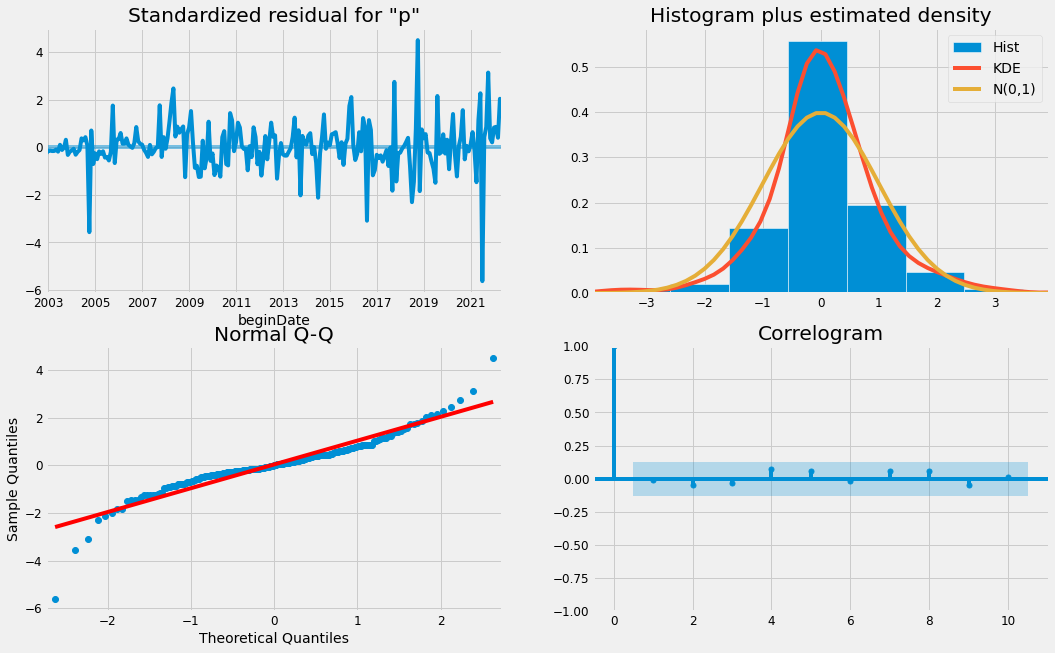

In [431]:
results.plot_diagnostics(figsize=(16, 10))
plt.show() #normal Q-Q plot good as it shows data fits 45 degree trend line suggesting normalized data

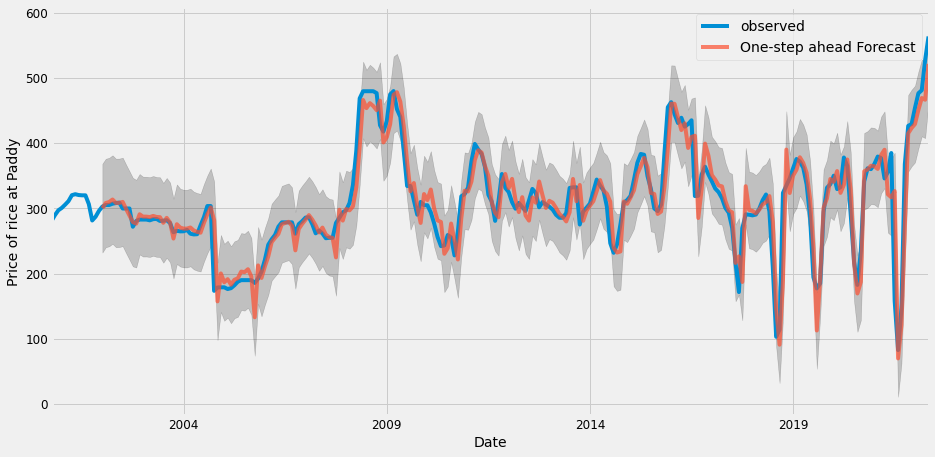

In [432]:
pred = results.get_prediction(start=pd.to_datetime('2002'), dynamic=False)
pred_ci = pred.conf_int()
ax = monthlymean['2000-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price of rice at Paddy')
plt.legend()
plt.show() #below is graph with one step ahead forecast for training the API

In [433]:
monthlypriceforecasted=pred.predicted_mean
monthlyactual=monthlymean['2002']
mse=((monthlypriceforecasted-monthlyactual)**2).mean()
print('Mean squared error is {}'.format(round(mse,2))) #mean squared error shows average difference between expected and measured

Mean squared error is 35.58


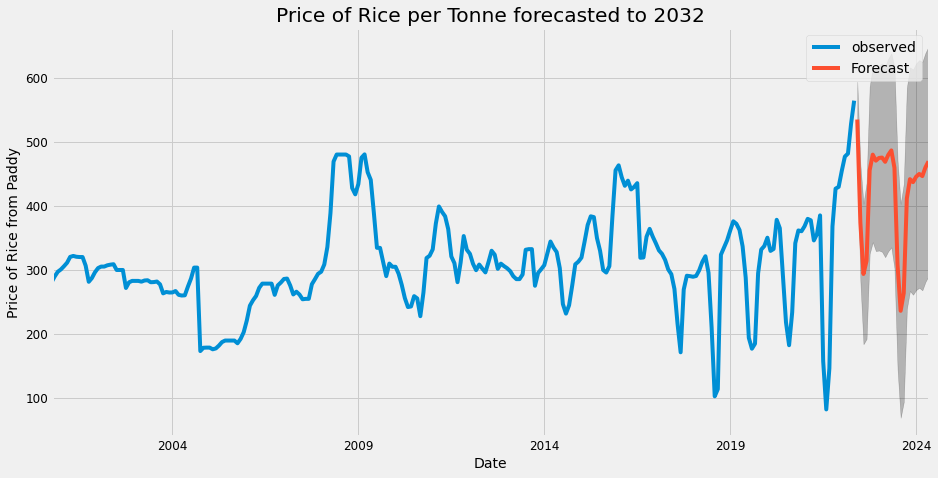

In [434]:
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = monthlymean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price of Rice from Paddy')
ax.set_title('Price of Rice per Tonne forecasted to 2032')
#ticks_data = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029]

plt.legend()
plt.show()#below is the final machine learning forecast. Ultimately due to the strong seasonality of the data near the end of the collected data it may skew the trend
#in the future the goal would be to use the arduino API/Sensor and comparing it to crop yields potentially to determine how to better care for crops to maximize yield. 